# Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import ot
import sys

from scipy.special import logsumexp
from scipy.sparse import csgraph
from sklearn.neighbors import KNeighborsTransformer

In [2]:
import LLOT_util

# Input data 


In [3]:
RNAseq = pd.read_csv('Data/dge_normalized.txt', sep='\t').T
BDTNP = pd.read_csv('Data/bdtnp.txt', sep='\t')
LOC_PATH = 'Data/geometry.txt'
col = BDTNP.columns.tolist()


location=pd.read_csv(LOC_PATH, delimiter=" ")

loc = location.values
loc = loc[0:3039,:]




# Construct KNN matrix and Laplacian matrix

In [4]:
from sklearn.neighbors import KNeighborsTransformer

# Construct KNN matrix, k = 8 at this example. 
transformer = KNeighborsTransformer(n_neighbors=8,mode='connectivity')
loc_con_knn = transformer.fit_transform(loc)

loc_dist = ot.dist(loc)
aff = (loc_con_knn+loc_con_knn.T)/2 # NN affinity matrix
L = csgraph.laplacian(aff)
L = L.toarray()


# Dimension Reduction (PCA) : Optional

In [5]:
X = RNAseq[col].values

Z = BDTNP.values


pca = PCA(n_components=40)
pca.fit(Z)
X = pca.transform(X)
Z = pca.transform(Z)

# Run LLOT / LLOT_stochastic  to get the coupling matrix

In [6]:
# Obtain coupling matrix 
pi = LLOT_util.LLOT(numitr=20, lambda1=1, lambda2=1, ST=Z, RNAseq=X, L = L,  Suggest=True) 

# Plot predicted spatial expression of genes 


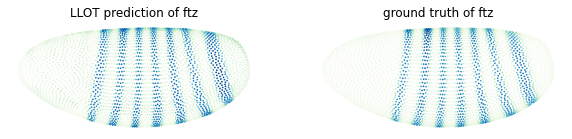

In [8]:
pltgene = 'ftz'

fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,2))

# LLOT prediction 
LLOT_pred = np.dot(pi,RNAseq[pltgene].values)
#ground truth 
gt = BDTNP[pltgene].values
    
axes[0].scatter(x=loc[:,0],y=loc[:,2],c=LLOT_pred,cmap='GnBu',s=0.5)
axes[0].axis('off')
axes[0].set_title('LLOT prediction of '+pltgene)

axes[1].scatter(x=loc[:,0],y=loc[:,2],c=gt,cmap='GnBu',s=0.5)
axes[1].axis('off')
axes[1].set_title('ground truth of '+pltgene)

plt.show()

# Infer cells' locations

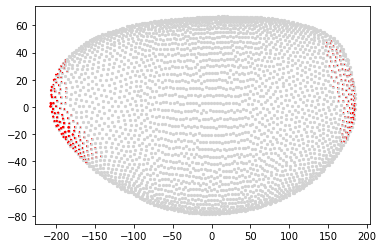

In [13]:
# pick a cell to infer possible locations:
cell = 131
prob = pi[:,cell]/pi[:,cell].sum()
prob[prob<=1e-6] = 0
prob = prob/prob.sum()

plt.scatter(x=loc[:,0],y=loc[:,2], s=5,color='lightgray')
plt.scatter(x=loc[:,0],y=loc[:,2], s=100*prob,color='Red',marker='*')